In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout
import os, io,zipfile,time
from PIL import Image
import tqdm
import cv2
from pathlib import Path
import joblib
from keras.preprocessing import image

from tensorflow.keras.layers import Add, Dense, ReLU, Reshape, LeakyReLU



In [144]:
# load data - data has training (tumor,no-tumor) and test (tumor,no-tumor) datasets

zip_file_path=("/content/MRIBrainTumor.zip")
extracted_dir=("/content/extracted_data")
!mkdir -p $extracted_dir
with zipfile.ZipFile(zip_file_path,'r') as zip_ref:
  zip_ref.extractall(extracted_dir)
!ls $extracted_dir

Testing  Training


In [145]:
from pathlib import Path
from keras.preprocessing import image
import numpy as np

# path_to_no_tumor_directory and "path_to_pituitary_tumor_directory"
no_tumor_path = Path("/content/extracted_data/Training/no_tumor")
pituitary_tumor_path = Path("/content/extracted_data/Training/pituitary_tumor")

images = []
labels = []

for img_path in no_tumor_path.glob("*jpg"):
    img = image.load_img(img_path, target_size=(28, 28),color_mode='grayscale')
    img_array = image.img_to_array(img)
    images.append(img_array)
    labels.append(0)

for img_path in pituitary_tumor_path.glob("*jpg"):
    img = image.load_img(img_path, target_size=(28, 28),color_mode='grayscale')
    img_array = image.img_to_array(img)
    images.append(img_array)
    labels.append(1)

xtrain = np.array(images)
ytrain = np.array(labels)


In [146]:
ytrain.shape #(1222,)
xtrain.shape  #(1222, 224, 224, 1)

(1222, 28, 28, 1)

In [147]:
#scale between -1 and 1  (negative: fake images by generator)
xtrain=xtrain.astype('float32')
xtrain=(xtrain-127.5)/127.5


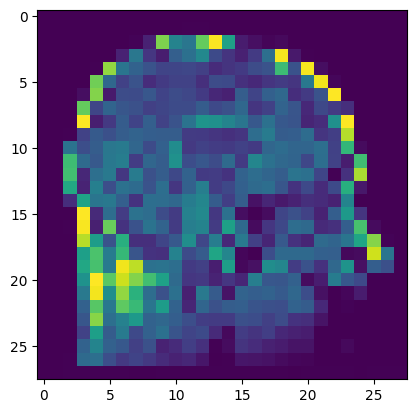

In [148]:
plt.imshow(xtrain[100])

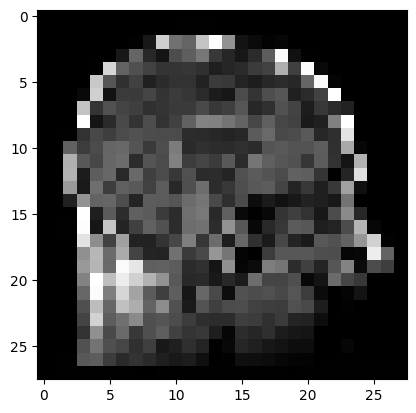

In [149]:
plt.imshow(xtrain[100].squeeze(),cmap='gray')

In [150]:
buffer_size=1222  #shuffle images
batch_size=80  #128
train_dataset=tf.data.Dataset.from_tensor_slices(xtrain).shuffle(buffer_size).batch(batch_size)

# creates a dataset from the training images, shuffles the dataset, and batches the shuffled elements into batches of a specified size, making it suitable for training the model.
# creates a tensorflow dataset (train_dataset) from a tensor of training images by slicing it along the first dimension- each element of the dataset will correspond to one element of the tensor (xtrain), preserving their order.

In [151]:
def generator_model():
  model=tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, input_shape=(100,)))
  # 1st klayer: a fully connected dense layer, 7 7 256 neurons # every vector has a 100 elements
  # input is cast to 4 dimensions 1- batchsize is the 1st d and remaining d are 7*7*256
  # output of this layer is a flattened vector : size 7*7*256 -> vector pass thtough a batch normalization layer (recenter our data to have a mean of zero & variants of 1)

  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Reshape((7,7,256))) # reshape the input to be in 4d: batch is 1st dimension and 3 d: 7*7*256-> start of the conv stack

  # transposed conv layers: from upsampling of data
  model.add(layers.Conv2DTranspose(128,(5,5),strides=[1,1],padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides=[2,2],padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  # produces an upsample img (tanh ensures img pixel values are in the range -1 to 1) of the same size as the img from our real dataset (img: 28*28*1)
  model.add(layers.Conv2DTranspose(1, (5,5),strides=[2,2], padding='same', activation='tanh'))

  return model
# performs upsampling of input data from a noise vector (d:100) to an actual generated img
# use strided convolusions

In [152]:
generator = generator_model()
generator.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 12544)             1266944   
                                                                 
 batch_normalization_20 (Ba  (None, 12544)             50176     
 tchNormalization)                                               
                                                                 
 re_lu_30 (ReLU)             (None, 12544)             0         
                                                                 
 reshape_10 (Reshape)        (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_12 (Conv2  (None, 7, 7, 128)         819328    
 DTranspose)                                                     
                                                                 
 batch_normalization_21 (Ba  (None, 7, 7, 128)       

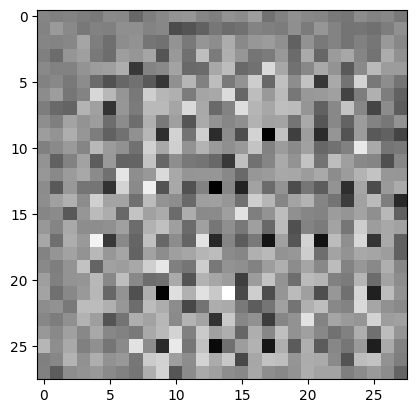

In [153]:
noise=tf.random.normal([1,100])  # generate Gaussian noise: vector size is 100= input dimension of our generator model
generated_image=generator(noise,training=False)  # False: see the generated img looks like
plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [154]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5*5),strides=(2*2), padding= 'same',input_shape=[28,28,1]))

    model.add(layers.BatchNormalization()) # reset the output to have mean of 0 and variance of 1
    model.add(layers.LeakyReLU(0.2)) # slight gradient for input values below zero: controlled by the input argument (o.2) that we pass into LR
    model.add(layers.Dropout(0.3)) # dropout: overfitting : turning off a % of neurons in the layer

    model.add(layers.Conv2D(128,(5*5),strides=(2*2), padding= 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid')) # single probability score: represent the prob that input img is real - sigmoid : prob score : 0-1

    return model


In [155]:
discriminator=discriminator_model()
discriminator.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 7, 7, 64)          40064     
                                                                 
 batch_normalization_23 (Ba  (None, 7, 7, 64)          256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 dropout_26 (Dropout)        (None, 7, 7, 64)          0         
                                                                 
 conv2d_9 (Conv2D)           (None, 2, 2, 128)         5120128   
                                                                 
 batch_normalization_24 (Ba  (None, 2, 2, 128)         512       
 tchNormalization)                                   

In [156]:
discriminator=discriminator_model()
output=discriminator(generated_image)
print(output)
# img (noise) from untrained generated model and pass this through the untrained discriminator ->  probability score: % 49

tf.Tensor([[0.49991632]], shape=(1, 1), dtype=float32)


In [157]:
bce=tf.keras.losses.BinaryCrossentropy()  # loss function

In [158]:
def discriminator_loss(real_output,fake_output):
  # 2 classes 1: real and 0:fake # imgs from real dataset classfied as real
  real_loss=bce(tf.ones_like(real_output),real_output) # compare output of discriminator to a tensor of 1s, this loss = real loss of the discriminator
  fake_loss=bce(tf.zeros_like(fake_output),fake_output) # tensor of 0s #fake binary crossentropy loss
  total_loss=real_loss+fake_loss # try to min total loss or max probabilty real imgs classifed as real and generated imgs are classfied as fake
  return total_loss


In [159]:
# Traning GANs # 2 Networks
# generator loss
def generator_loss(fake_output):
  gen_loss=bce(tf.ones_like(fake_output),fake_output) # input is fake_output = output of discriminator for fake data generated by the generator & compare the output to a tensor of all 1s
  # objective: fools discriminator: classifies fake data as real
  return gen_loss

In [160]:
# optimizers for both # Adam preforms gredient descent using an exponentially weighted average of gradients
generator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.002,beta_1=0.5)
discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.002,beta_1=0.5)

In [161]:
# training  # interrupt start from the last checkpoint
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Specify the directory to save checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')

# Create a tf.train.Checkpoint object
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [162]:
# training process
epochs=50
noise_dim=100
num_examples_to_generate=16 # after epoch of training , generate 16 examples from our GAN to see that what the generated images looked like; these 10 images generated usign 16 different noise vectors, each dimensionality 100

seed=tf.random.normal([num_examples_to_generate,noise_dim])

In [163]:
@tf.function() #python animation as a transformation tool & creates data flow graphs out of ur Py code # generate NN graph
def train_step(images):  # images as input
  noise=tf.random.normal([batch_size,noise_dim]) # @ every step generate a batch of noise
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # GradientTape : gradient descent -> train NN - 2 types of NN
    generated_images=generator(noise,training=True) #generate fake images from generator -> trainign true

    real_output=discriminator(images,training=True) # train discriminator : real and fake images
    fake_output=discriminator(generated_images,training=True)

    disc_loss=discriminator_loss(real_output,fake_output)
    gen_loss=generator_loss(fake_output)

  gradient_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradient_of_discriminator=disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

  return(gen_loss,disc_loss,tf.reduce_mean(real_output),tf.reduce_mean(fake_output))
  # return losses and accuracy of discriminator on real data and fake data

In [164]:
# helper function generate & plot images to get the generator to generate images form the test input that we have specified
def generate_and_plot_images(model,epoch,test_input):
  predictions=model(test_input,training=False) # output of generator for test noise input that we set up earlier
  fig=plt.figure(figsize=(8,4)) # plot this output to see how the generator improves over time

  for i in range (predictions.shape[0]):
    plt.subplot(4,4,i+1)
    pred=(predictions[i,:,:,0]+1)*127.5
    pred=np.array(pred)
    plt.imshow(pred.astype(np.uint8),cmap='gray')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [165]:
# actual training
def train(dataset,epochs):
  gen_loss_list=[]
  disc_loss_list=[] # for plotting
  real_score_list=[]
  fake_score_list=[] # accuracy

  for epoch in tqdm(range(epochs)):
    start=time.time()
    num_batches=len(dataset)

    print(f'Training started with epochs {epoch+1} with {num_batches} bateches...')

    total_gen_loss=0
    total_disc_loss=0

    for batch in dataset:
      generator_loss, discriminator_loss,real_score, fake_score=train_step(batch)
      total_gen_loss+=generator_loss
      total_disc_loss+=discriminator_loss

    mean_gen_loss=total_gen_loss/num_batches # average loss for epoch
    mean_disc_loss=total_disc_loss/num_batches

    print(f'Losses after epoch %5d: generator %.3f, discriminator %.3f,  real_score %.2f%%, fake_score %.2f%%' %
      (epoch+1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

    generate_and_plot_images(generator, epoch+1,seed)

    gen_loss_list.append(mean_gen_loss)
    disc_loss_list.append(mean_disc_loss)
    real_score_list.append(real_score)  # accuracy
    fake_score_list.append(fake_score)

    if (epoch+1)%10==0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

  return gen_loss_list, disc_loss_list,real_score_list,fake_score_list


  0%|          | 0/50 [00:00<?, ?it/s]

Training started with epochs 1 with 16 bateches...
Losses after epoch     1: generator 3.976, discriminator 1.030,  real_score 40.76%, fake_score 2.81%


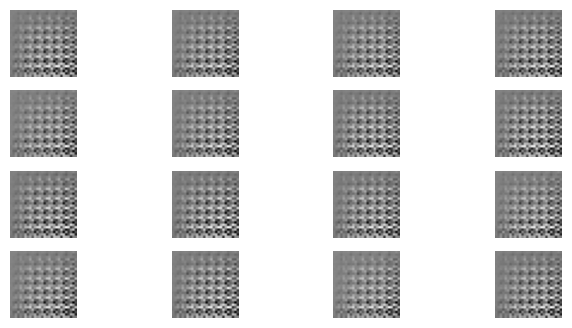

  2%|▏         | 1/50 [00:07<06:10,  7.56s/it]

Time for epoch 1 is 7.559716463088989 sec
Training started with epochs 2 with 16 bateches...
Losses after epoch     2: generator 0.351, discriminator 1.720,  real_score 78.69%, fake_score 72.52%


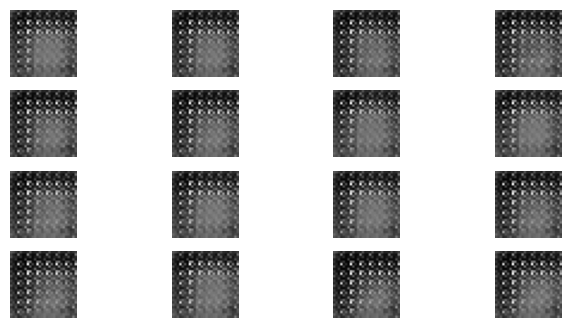

  4%|▍         | 2/50 [00:08<03:02,  3.79s/it]

Time for epoch 2 is 1.1531658172607422 sec
Training started with epochs 3 with 16 bateches...
Losses after epoch     3: generator 1.378, discriminator 0.829,  real_score 67.81%, fake_score 28.47%


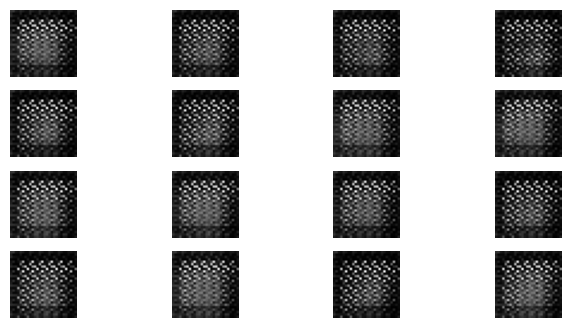

  6%|▌         | 3/50 [00:09<02:02,  2.60s/it]

Time for epoch 3 is 1.1870124340057373 sec
Training started with epochs 4 with 16 bateches...
Losses after epoch     4: generator 1.500, discriminator 1.166,  real_score 45.64%, fake_score 24.78%


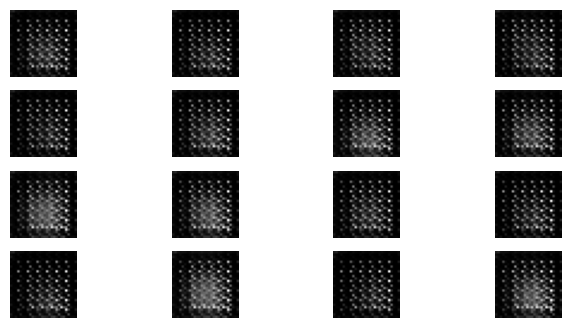

  8%|▊         | 4/50 [00:12<01:56,  2.53s/it]

Time for epoch 4 is 2.4259116649627686 sec
Training started with epochs 5 with 16 bateches...
Losses after epoch     5: generator 1.494, discriminator 1.264,  real_score 45.77%, fake_score 24.57%


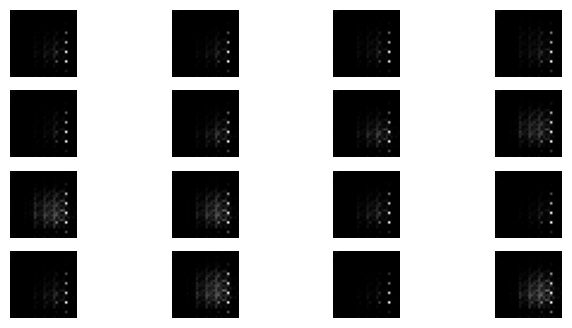

 10%|█         | 5/50 [00:13<01:35,  2.13s/it]

Time for epoch 5 is 1.4077661037445068 sec
Training started with epochs 6 with 16 bateches...
Losses after epoch     6: generator 0.242, discriminator 1.767,  real_score 94.16%, fake_score 79.21%


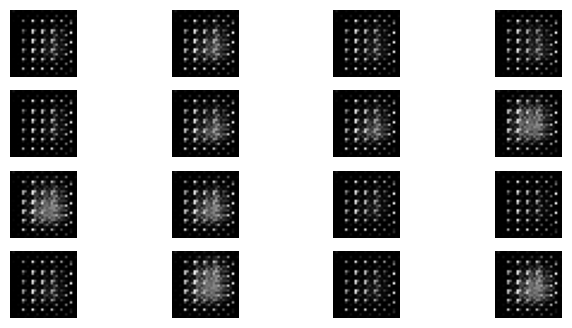

 12%|█▏        | 6/50 [00:14<01:18,  1.79s/it]

Time for epoch 6 is 1.1384057998657227 sec
Training started with epochs 7 with 16 bateches...
Losses after epoch     7: generator 1.018, discriminator 1.117,  real_score 57.22%, fake_score 38.78%


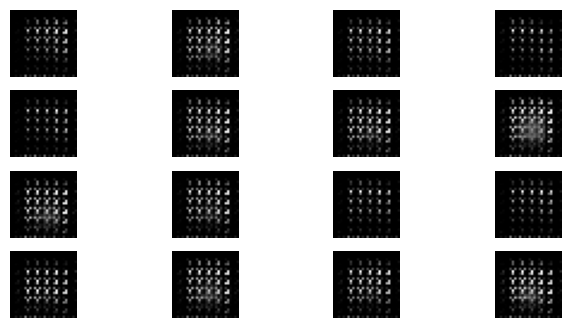

 14%|█▍        | 7/50 [00:16<01:08,  1.59s/it]

Time for epoch 7 is 1.1682260036468506 sec
Training started with epochs 8 with 16 bateches...
Losses after epoch     8: generator 0.937, discriminator 0.993,  real_score 66.83%, fake_score 40.99%


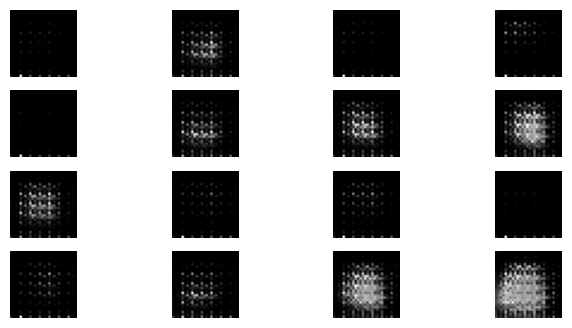

 16%|█▌        | 8/50 [00:17<01:00,  1.45s/it]

Time for epoch 8 is 1.1521708965301514 sec
Training started with epochs 9 with 16 bateches...
Losses after epoch     9: generator 1.306, discriminator 1.146,  real_score 48.40%, fake_score 29.97%


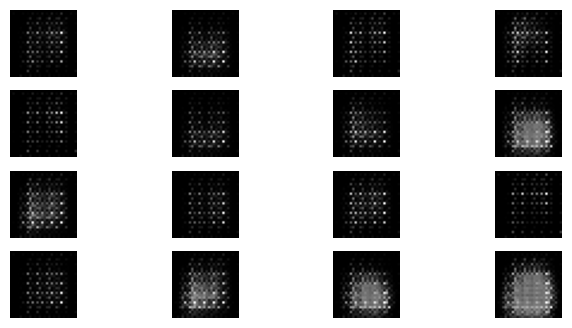

 18%|█▊        | 9/50 [00:18<00:58,  1.44s/it]

Time for epoch 9 is 1.3987185955047607 sec
Training started with epochs 10 with 16 bateches...
Losses after epoch    10: generator 1.018, discriminator 1.175,  real_score 55.94%, fake_score 39.06%


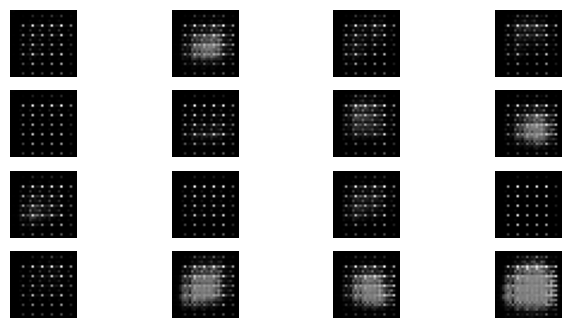

 20%|██        | 10/50 [00:20<01:05,  1.63s/it]

Time for epoch 10 is 2.074652910232544 sec
Training started with epochs 11 with 16 bateches...
Losses after epoch    11: generator 0.519, discriminator 1.171,  real_score 83.08%, fake_score 60.64%


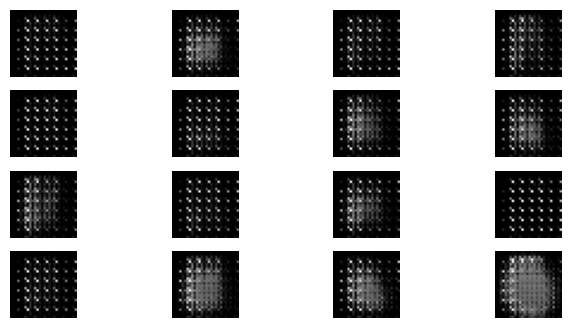

 22%|██▏       | 11/50 [00:21<00:57,  1.48s/it]

Time for epoch 11 is 1.1443142890930176 sec
Training started with epochs 12 with 16 bateches...
Losses after epoch    12: generator 2.178, discriminator 0.762,  real_score 62.96%, fake_score 15.77%


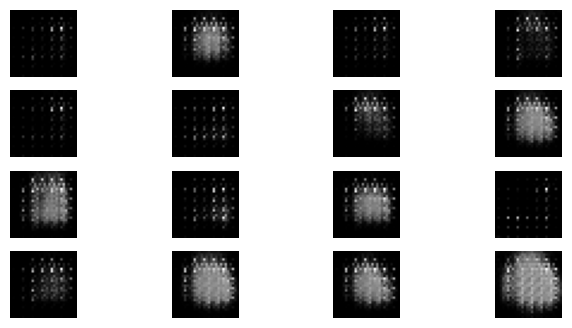

 24%|██▍       | 12/50 [00:22<00:52,  1.38s/it]

Time for epoch 12 is 1.1397626399993896 sec
Training started with epochs 13 with 16 bateches...
Losses after epoch    13: generator 2.226, discriminator 0.909,  real_score 51.54%, fake_score 13.25%


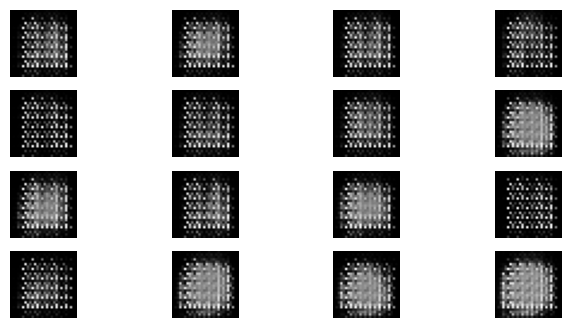

 26%|██▌       | 13/50 [00:24<00:48,  1.31s/it]

Time for epoch 13 is 1.161238670349121 sec
Training started with epochs 14 with 16 bateches...
Losses after epoch    14: generator 0.731, discriminator 1.198,  real_score 67.60%, fake_score 50.59%


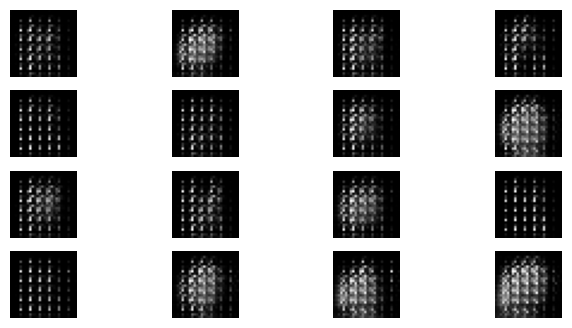

 28%|██▊       | 14/50 [00:25<00:45,  1.27s/it]

Time for epoch 14 is 1.1647918224334717 sec
Training started with epochs 15 with 16 bateches...
Losses after epoch    15: generator 1.321, discriminator 0.835,  real_score 67.22%, fake_score 30.00%


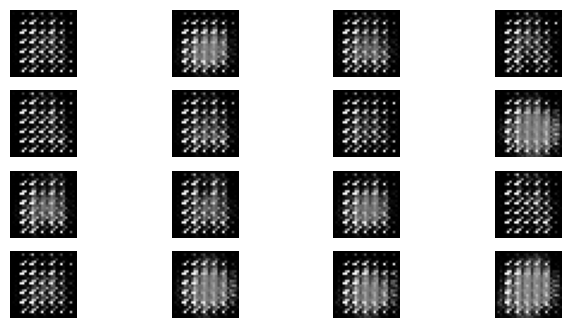

 30%|███       | 15/50 [00:26<00:43,  1.25s/it]

Time for epoch 15 is 1.1960997581481934 sec
Training started with epochs 16 with 16 bateches...
Losses after epoch    16: generator 1.029, discriminator 1.169,  real_score 54.37%, fake_score 39.17%


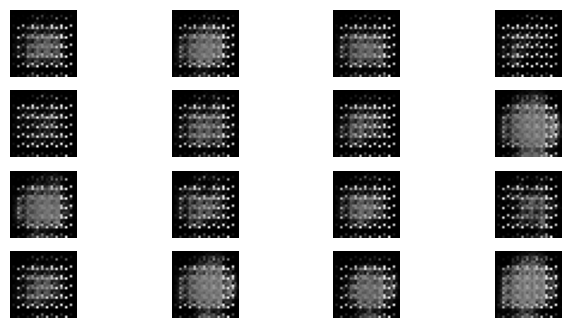

 32%|███▏      | 16/50 [00:28<00:46,  1.36s/it]

Time for epoch 16 is 1.6165413856506348 sec
Training started with epochs 17 with 16 bateches...
Losses after epoch    17: generator 0.339, discriminator 1.603,  real_score 84.78%, fake_score 72.87%


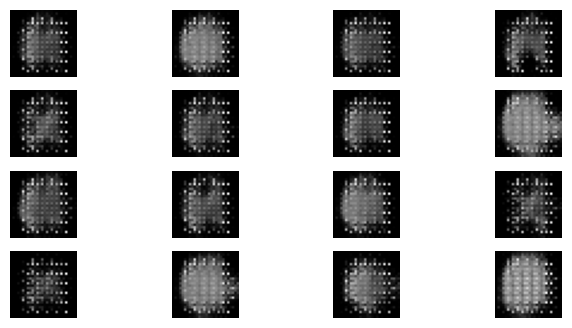

 34%|███▍      | 17/50 [00:29<00:42,  1.30s/it]

Time for epoch 17 is 1.1579387187957764 sec
Training started with epochs 18 with 16 bateches...
Losses after epoch    18: generator 2.911, discriminator 1.201,  real_score 34.37%, fake_score 6.67%


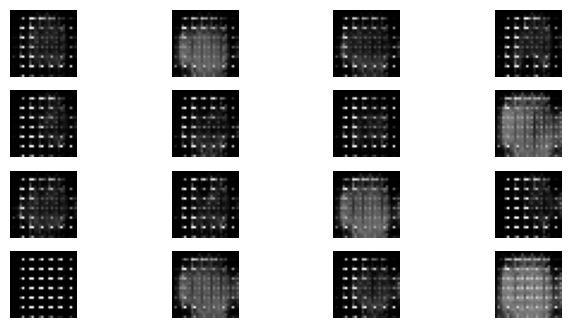

 36%|███▌      | 18/50 [00:30<00:42,  1.33s/it]

Time for epoch 18 is 1.3839335441589355 sec
Training started with epochs 19 with 16 bateches...
Losses after epoch    19: generator 1.145, discriminator 0.950,  real_score 65.72%, fake_score 34.76%


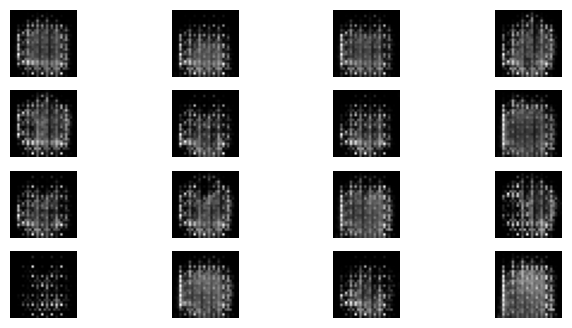

 38%|███▊      | 19/50 [00:32<00:41,  1.33s/it]

Time for epoch 19 is 1.3215982913970947 sec
Training started with epochs 20 with 16 bateches...
Losses after epoch    20: generator 0.805, discriminator 1.019,  real_score 73.81%, fake_score 47.68%


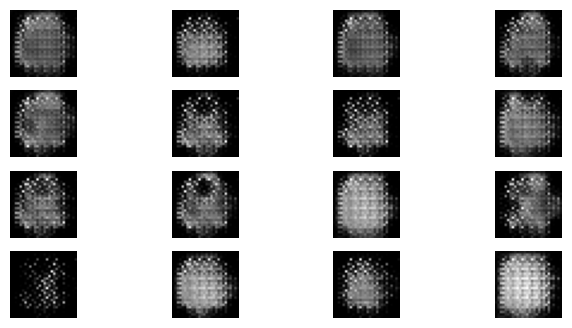

 40%|████      | 20/50 [00:33<00:41,  1.38s/it]

Time for epoch 20 is 1.5049104690551758 sec
Training started with epochs 21 with 16 bateches...
Losses after epoch    21: generator 1.767, discriminator 1.055,  real_score 49.39%, fake_score 19.46%


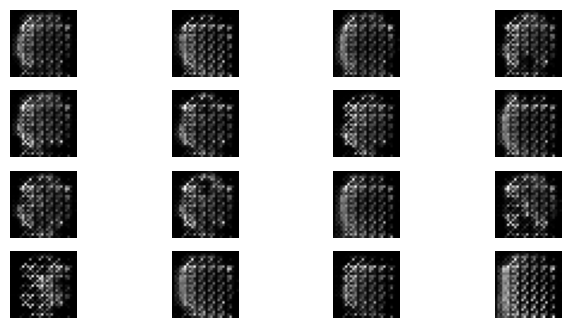

 42%|████▏     | 21/50 [00:34<00:38,  1.32s/it]

Time for epoch 21 is 1.1735508441925049 sec
Training started with epochs 22 with 16 bateches...
Losses after epoch    22: generator 1.937, discriminator 2.451,  real_score 14.50%, fake_score 16.72%


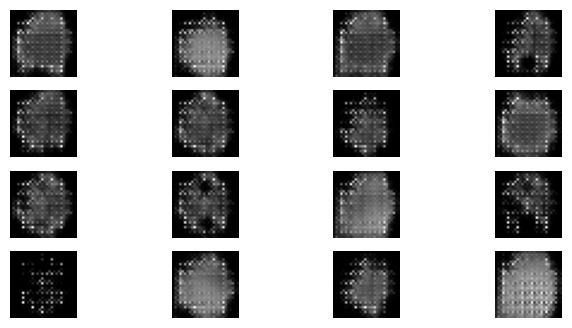

 44%|████▍     | 22/50 [00:36<00:39,  1.43s/it]

Time for epoch 22 is 1.6767454147338867 sec
Training started with epochs 23 with 16 bateches...
Losses after epoch    23: generator 1.142, discriminator 1.242,  real_score 47.07%, fake_score 34.33%


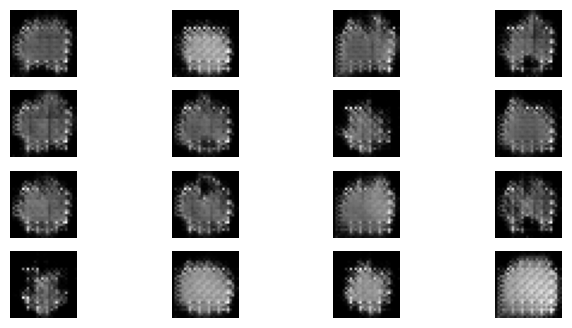

 46%|████▌     | 23/50 [00:37<00:36,  1.36s/it]

Time for epoch 23 is 1.1937921047210693 sec
Training started with epochs 24 with 16 bateches...
Losses after epoch    24: generator 0.764, discriminator 1.135,  real_score 67.62%, fake_score 48.76%


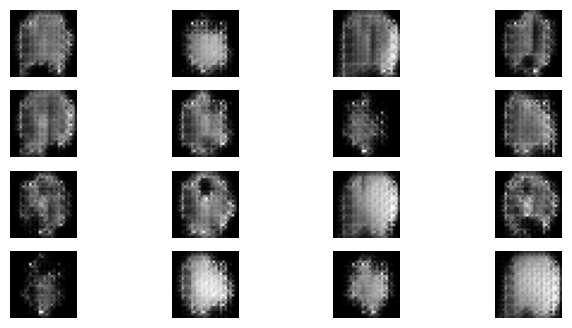

 48%|████▊     | 24/50 [00:38<00:34,  1.32s/it]

Time for epoch 24 is 1.2071774005889893 sec
Training started with epochs 25 with 16 bateches...
Losses after epoch    25: generator 2.274, discriminator 0.979,  real_score 46.66%, fake_score 12.10%


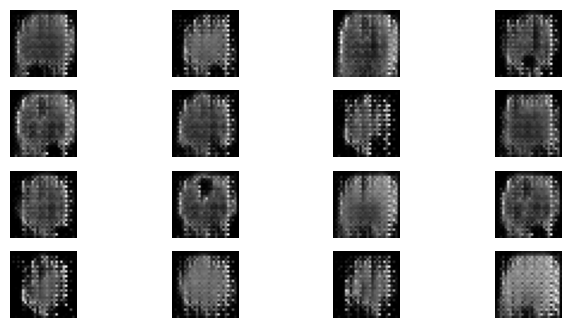

 50%|█████     | 25/50 [00:39<00:32,  1.28s/it]

Time for epoch 25 is 1.2068865299224854 sec
Training started with epochs 26 with 16 bateches...
Losses after epoch    26: generator 1.118, discriminator 1.096,  real_score 55.77%, fake_score 35.39%


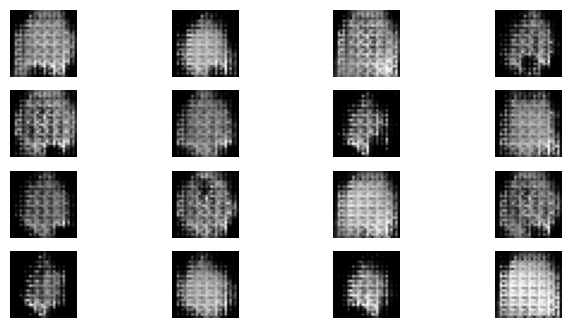

 52%|█████▏    | 26/50 [00:41<00:30,  1.26s/it]

Time for epoch 26 is 1.20452880859375 sec
Training started with epochs 27 with 16 bateches...
Losses after epoch    27: generator 0.868, discriminator 1.091,  real_score 63.73%, fake_score 44.12%


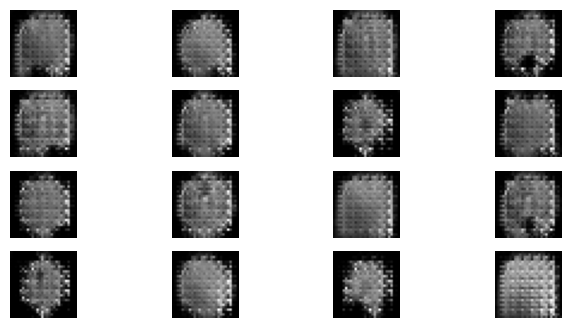

 54%|█████▍    | 27/50 [00:42<00:30,  1.31s/it]

Time for epoch 27 is 1.4210731983184814 sec
Training started with epochs 28 with 16 bateches...
Losses after epoch    28: generator 0.991, discriminator 0.981,  real_score 67.10%, fake_score 40.06%


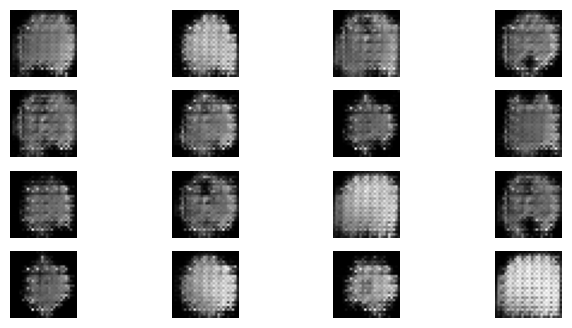

 56%|█████▌    | 28/50 [00:44<00:32,  1.46s/it]

Time for epoch 28 is 1.8004014492034912 sec
Training started with epochs 29 with 16 bateches...
Losses after epoch    29: generator 0.828, discriminator 1.719,  real_score 40.83%, fake_score 46.44%


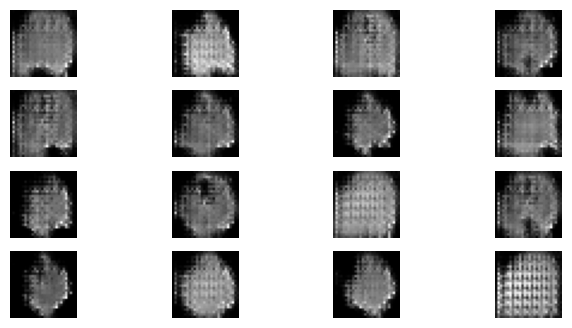

 58%|█████▊    | 29/50 [00:45<00:28,  1.38s/it]

Time for epoch 29 is 1.18959379196167 sec
Training started with epochs 30 with 16 bateches...
Losses after epoch    30: generator 1.950, discriminator 0.836,  real_score 58.77%, fake_score 18.16%


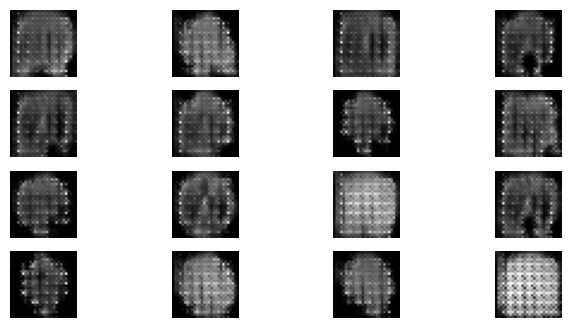

 60%|██████    | 30/50 [00:47<00:28,  1.41s/it]

Time for epoch 30 is 1.4692339897155762 sec
Training started with epochs 31 with 16 bateches...
Losses after epoch    31: generator 1.570, discriminator 0.802,  real_score 63.10%, fake_score 24.79%


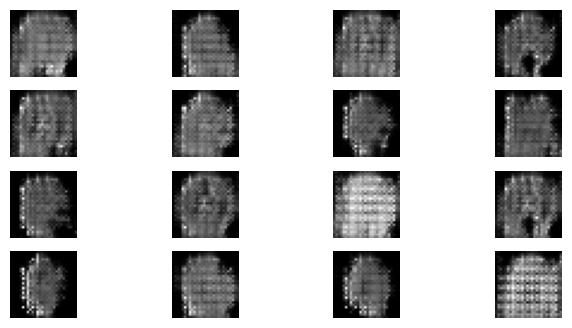

 62%|██████▏   | 31/50 [00:48<00:25,  1.35s/it]

Time for epoch 31 is 1.2000911235809326 sec
Training started with epochs 32 with 16 bateches...
Losses after epoch    32: generator 0.680, discriminator 1.170,  real_score 79.44%, fake_score 54.89%


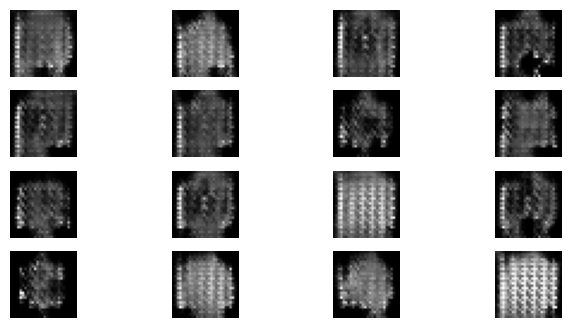

 64%|██████▍   | 32/50 [00:49<00:23,  1.30s/it]

Time for epoch 32 is 1.1718003749847412 sec
Training started with epochs 33 with 16 bateches...
Losses after epoch    33: generator 0.758, discriminator 1.135,  real_score 74.26%, fake_score 50.92%


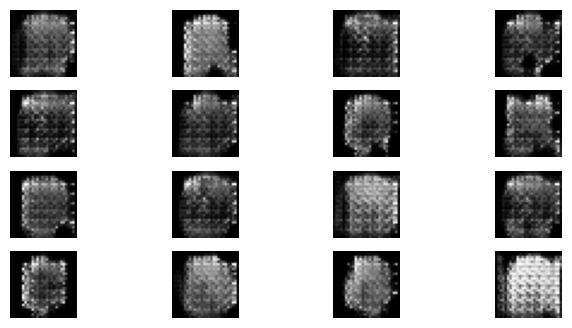

 66%|██████▌   | 33/50 [00:50<00:21,  1.26s/it]

Time for epoch 33 is 1.180140733718872 sec
Training started with epochs 34 with 16 bateches...
Losses after epoch    34: generator 1.020, discriminator 0.927,  real_score 68.75%, fake_score 39.18%


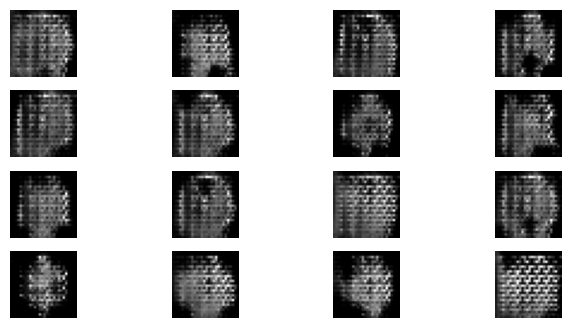

 68%|██████▊   | 34/50 [00:52<00:22,  1.40s/it]

Time for epoch 34 is 1.7097086906433105 sec
Training started with epochs 35 with 16 bateches...
Losses after epoch    35: generator 1.107, discriminator 1.771,  real_score 33.68%, fake_score 35.91%


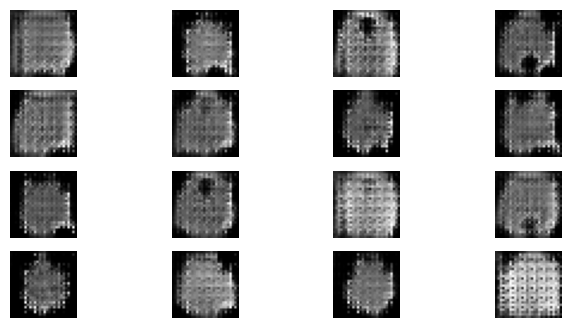

 70%|███████   | 35/50 [00:53<00:20,  1.34s/it]

Time for epoch 35 is 1.2013142108917236 sec
Training started with epochs 36 with 16 bateches...
Losses after epoch    36: generator 1.618, discriminator 0.982,  real_score 53.68%, fake_score 22.93%


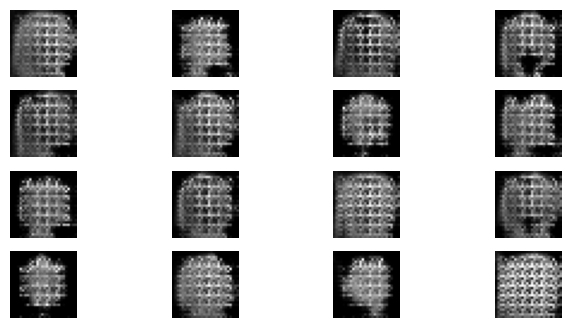

 72%|███████▏  | 36/50 [00:55<00:19,  1.39s/it]

Time for epoch 36 is 1.4809129238128662 sec
Training started with epochs 37 with 16 bateches...
Losses after epoch    37: generator 0.932, discriminator 1.109,  real_score 59.69%, fake_score 41.64%


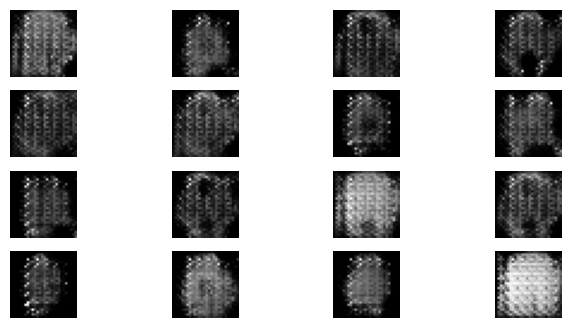

 74%|███████▍  | 37/50 [00:56<00:18,  1.44s/it]

Time for epoch 37 is 1.5715909004211426 sec
Training started with epochs 38 with 16 bateches...
Losses after epoch    38: generator 1.176, discriminator 0.976,  real_score 59.82%, fake_score 33.60%


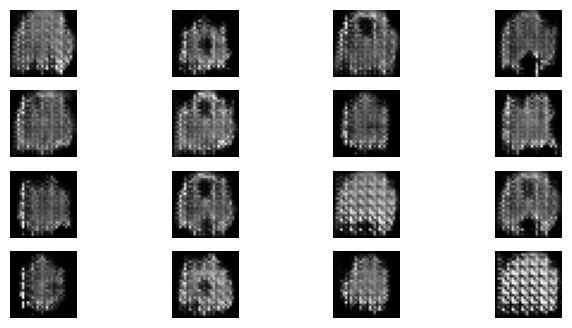

 76%|███████▌  | 38/50 [00:57<00:16,  1.40s/it]

Time for epoch 38 is 1.2859597206115723 sec
Training started with epochs 39 with 16 bateches...
Losses after epoch    39: generator 0.809, discriminator 1.058,  real_score 72.76%, fake_score 47.61%


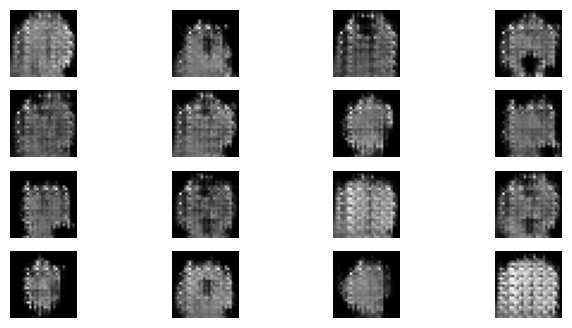

 78%|███████▊  | 39/50 [00:59<00:14,  1.34s/it]

Time for epoch 39 is 1.2034013271331787 sec
Training started with epochs 40 with 16 bateches...
Losses after epoch    40: generator 0.726, discriminator 1.170,  real_score 75.25%, fake_score 52.98%


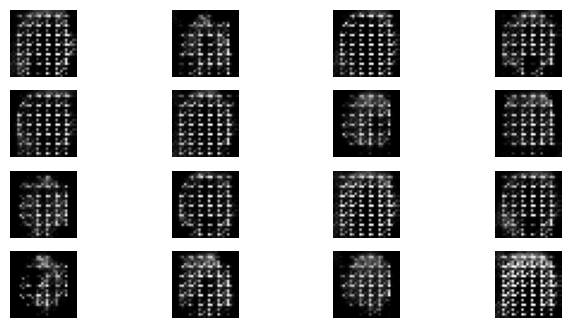

 80%|████████  | 40/50 [01:01<00:15,  1.55s/it]

Time for epoch 40 is 2.032569169998169 sec
Training started with epochs 41 with 16 bateches...
Losses after epoch    41: generator 0.892, discriminator 1.267,  real_score 60.29%, fake_score 44.87%


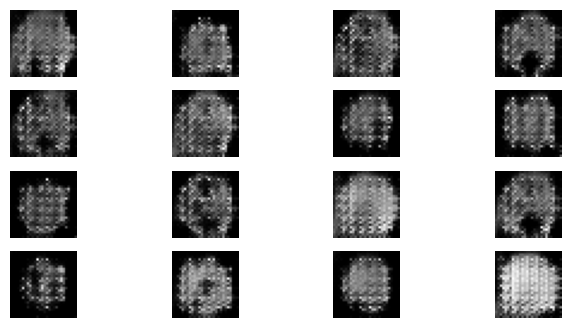

 82%|████████▏ | 41/50 [01:02<00:12,  1.44s/it]

Time for epoch 41 is 1.1912333965301514 sec
Training started with epochs 42 with 16 bateches...
Losses after epoch    42: generator 1.072, discriminator 1.554,  real_score 40.88%, fake_score 37.68%


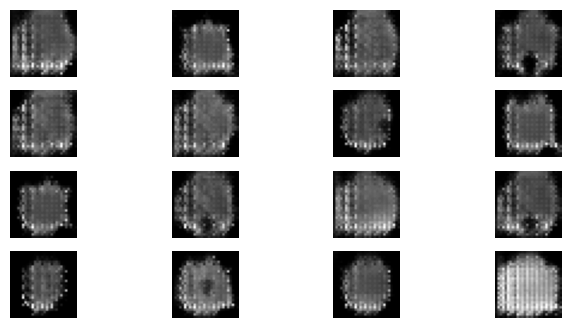

 84%|████████▍ | 42/50 [01:03<00:10,  1.37s/it]

Time for epoch 42 is 1.2050361633300781 sec
Training started with epochs 43 with 16 bateches...
Losses after epoch    43: generator 1.226, discriminator 0.916,  real_score 68.19%, fake_score 32.92%


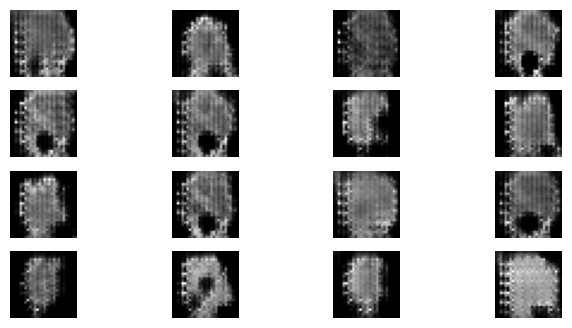

 86%|████████▌ | 43/50 [01:04<00:09,  1.34s/it]

Time for epoch 43 is 1.2520790100097656 sec
Training started with epochs 44 with 16 bateches...
Losses after epoch    44: generator 0.642, discriminator 1.040,  real_score 83.55%, fake_score 54.71%


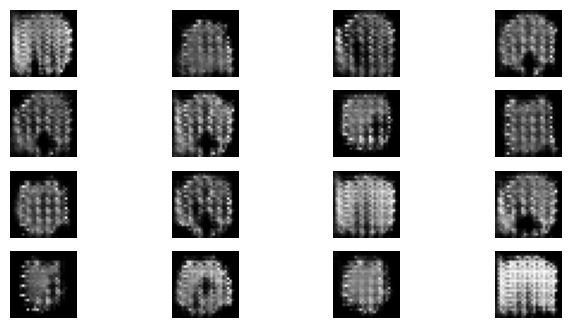

 88%|████████▊ | 44/50 [01:06<00:07,  1.31s/it]

Time for epoch 44 is 1.2361316680908203 sec
Training started with epochs 45 with 16 bateches...
Losses after epoch    45: generator 1.251, discriminator 0.698,  real_score 78.10%, fake_score 33.04%


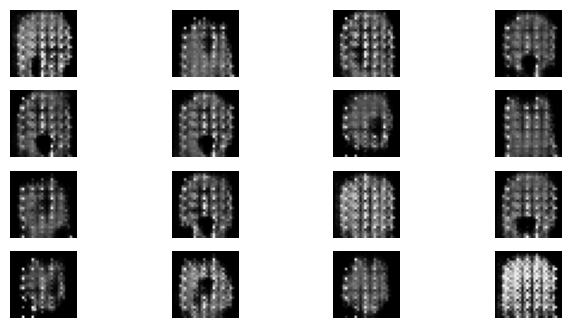

 90%|█████████ | 45/50 [01:07<00:06,  1.34s/it]

Time for epoch 45 is 1.4199235439300537 sec
Training started with epochs 46 with 16 bateches...
Losses after epoch    46: generator 1.556, discriminator 0.794,  real_score 64.17%, fake_score 23.78%


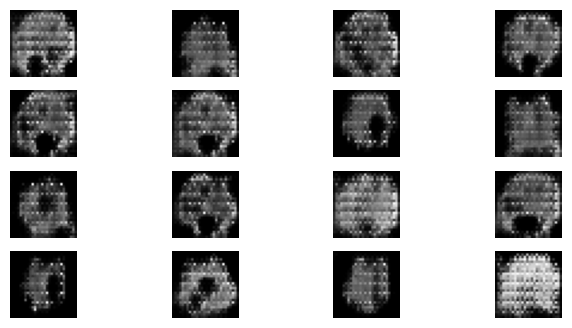

 92%|█████████▏| 46/50 [01:09<00:06,  1.61s/it]

Time for epoch 46 is 2.237338066101074 sec
Training started with epochs 47 with 16 bateches...
Losses after epoch    47: generator 1.272, discriminator 0.588,  real_score 85.69%, fake_score 32.16%


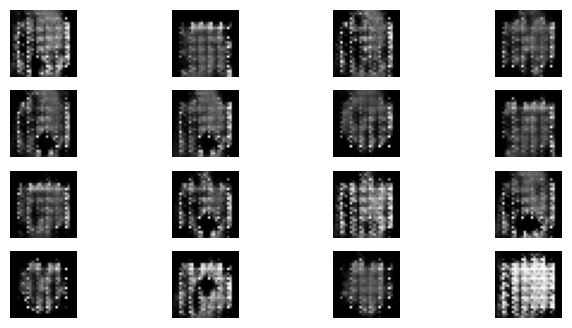

 94%|█████████▍| 47/50 [01:10<00:04,  1.50s/it]

Time for epoch 47 is 1.2272415161132812 sec
Training started with epochs 48 with 16 bateches...
Losses after epoch    48: generator 2.458, discriminator 1.156,  real_score 38.97%, fake_score 10.43%


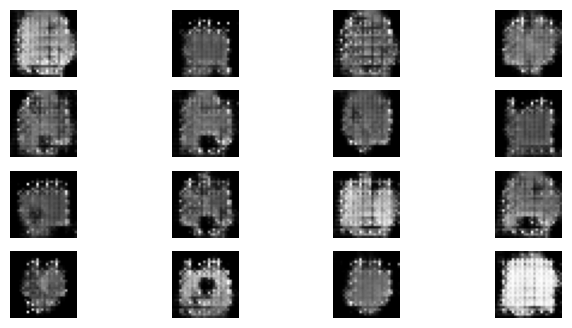

 96%|█████████▌| 48/50 [01:12<00:02,  1.42s/it]

Time for epoch 48 is 1.2166876792907715 sec
Training started with epochs 49 with 16 bateches...
Losses after epoch    49: generator 0.940, discriminator 0.924,  real_score 74.66%, fake_score 42.34%


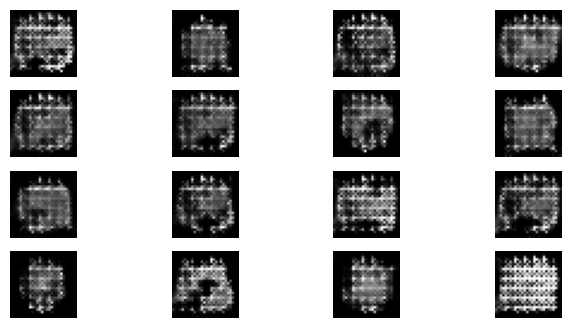

 98%|█████████▊| 49/50 [01:13<00:01,  1.35s/it]

Time for epoch 49 is 1.1816272735595703 sec
Training started with epochs 50 with 16 bateches...
Losses after epoch    50: generator 0.912, discriminator 0.828,  real_score 85.45%, fake_score 44.96%


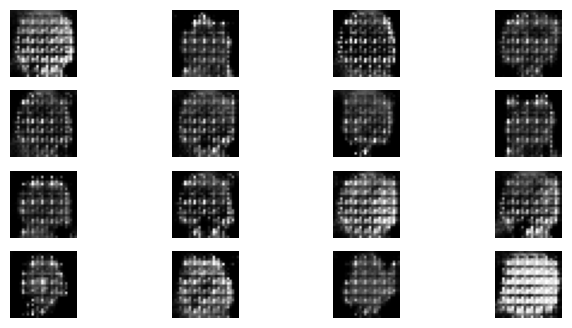

100%|██████████| 50/50 [01:14<00:00,  1.50s/it]

Time for epoch 50 is 1.506558895111084 sec


In [166]:
from tqdm import tqdm
# start training process
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list=train(train_dataset,epochs=epochs)

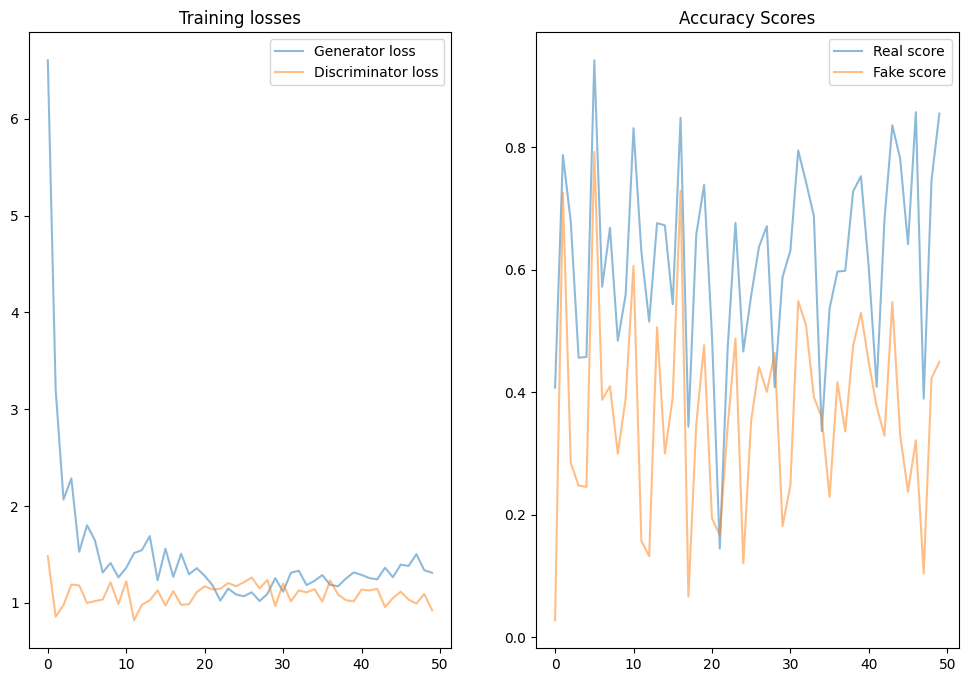

In [167]:
# generated images from the generator improves over time
# discriminator performance becomes worse over time (its loss increases over time)
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

ax1.plot(gen_loss_epochs, label='Generator loss', alpha=0.5)
ax1.plot(disc_loss_epochs, label='Discriminator loss', alpha=0.5)
ax1.set_title('Training losses')
ax1.legend()

ax2.plot(real_score_list, label='Real score',alpha=0.5)
ax2.plot(fake_score_list, label='Fake score',alpha=0.5)
ax2.set_title('Accuracy Scores')
ax2.legend()